# TCRpeg p infer distribution heatmap

In [275]:
# Add autoreload for easier development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [276]:
from tcrpeg_toolkit.distribution_handler import DistributionHeatmapPlotter

In [239]:
plot_heatmap = DistributionHeatmapPlotter(data='/Users/vanessamhanna/Nextcloud/TCRpeg/p_infer/', distance_metric='jsd')

INFO - Loading distributions and calculating distance matrix...


INFO - Loaded 88 distributions with their IDs
INFO - Jensen-Shannon divergence metric selected.


WARNING - No metadata provided. Skipping metadata processing.
WARNING - No metadata provided. Skipping multi-index creation.
WARNING - No multi-index found. Skipping annotation.
WARNING - No multi-index found. Skipping metadata color assignment.


/opt/homebrew/Caskroom/miniconda/base/envs/tcrpeg_env/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/homebrew/Caskroom/miniconda/base/envs/tcrpeg_env/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


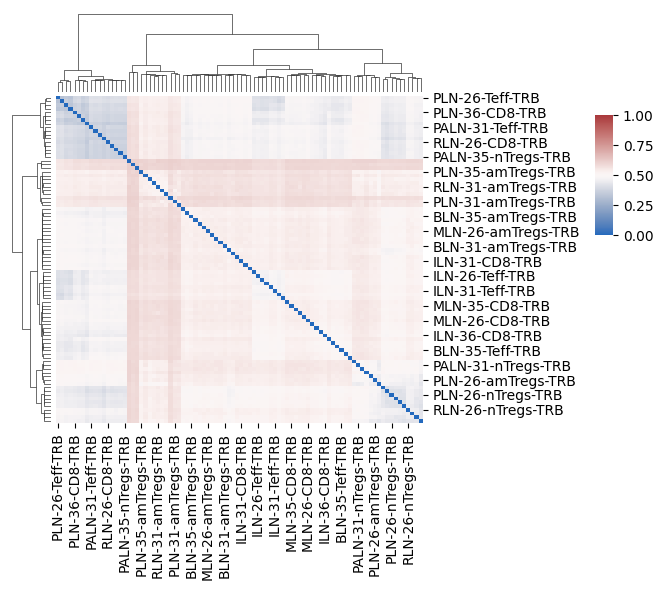

In [240]:
plot_heatmap.run(normalize=True,save=False)

In [278]:
plot_heatmap_metadata = DistributionHeatmapPlotter(data='/Users/vanessamhanna/Nextcloud/TCRpeg/p_infer/', metadata='/Users/vanessamhanna/Nextcloud/TCRpeg/metadata.csv',
                                                   distance_metric='jsd')

INFO - Data loaded from /Users/vanessamhanna/Nextcloud/TCRpeg/metadata.csv
INFO - Loading distributions and calculating distance matrix...


INFO - Loaded 136 distributions with their IDs
INFO - Jensen-Shannon divergence metric selected.


In [289]:
plot_heatmap_metadata.color_palettes['type']


{'colors': 0      (0.4980392156862745, 0.788235294117647, 0.4980...
 1      (0.7450980392156863, 0.6823529411764706, 0.831...
 2      (0.4980392156862745, 0.788235294117647, 0.4980...
 3      (0.7450980392156863, 0.6823529411764706, 0.831...
 4      (0.4980392156862745, 0.788235294117647, 0.4980...
                              ...                        
 131    (0.7450980392156863, 0.6823529411764706, 0.831...
 132    (0.7450980392156863, 0.6823529411764706, 0.831...
 133    (0.7450980392156863, 0.6823529411764706, 0.831...
 134    (0.7450980392156863, 0.6823529411764706, 0.831...
 135    (0.7450980392156863, 0.6823529411764706, 0.831...
 Name: type, Length: 136, dtype: object,
 'lut': {'superficial': (0.4980392156862745,
   0.788235294117647,
   0.4980392156862745),
  'deep': (0.7450980392156863, 0.6823529411764706, 0.8313725490196079)}}

In [294]:
custom_palette= {
    'cell_pop': {'Teff': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
  'amTregs': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
  'nTregs': (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
  'CD8': (0.9058823529411765, 0.1607843137254902, 0.5411764705882353)},
    'organ':{ 'PLN': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
  'RLN': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
  'ILN': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
  'BLN': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
  'PALN': (1.0, 0.8509803921568627, 0.1843137254901961),
  'MLN': (0.4, 0.7607843137254902, 0.6470588235294118)},
   'type': {'superficial': (0.8509803921568627,
   0,
   0),
  'deep': (0, 0, 0)
    }}
   

INFO - Metadata id matches the data names (name_p_infer.npy). Sorting by id.
INFO - Using specified columns for multi-index creation.


/opt/homebrew/Caskroom/miniconda/base/envs/tcrpeg_env/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniconda/base/envs/tcrpeg_env/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/homebrew/Caskroom/miniconda/base/envs/tcrpeg_env/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniconda/base/envs/tcrpeg_env/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierar

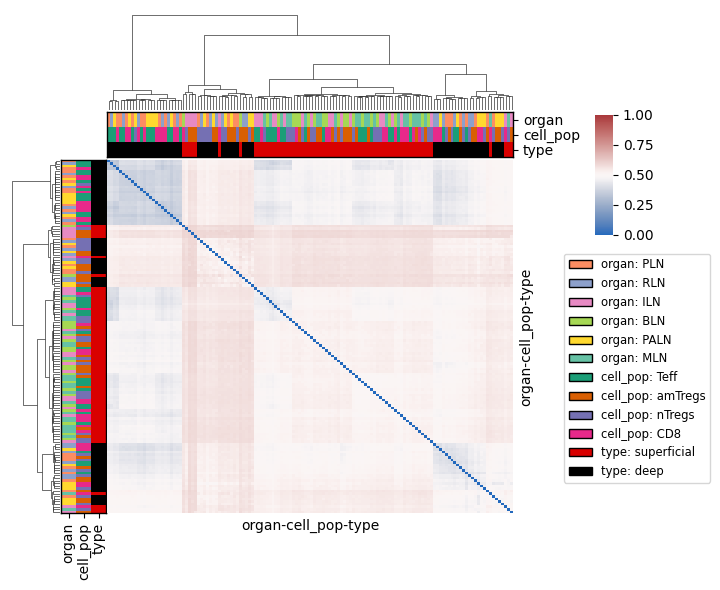

In [295]:
plot_heatmap_metadata.run(normalize=True, columns=['organ', 'cell_pop', 'type'], palette_mapping=custom_palette)

## Calculating distance before plotting

In [19]:
from tcrpeg_toolkit.distribution_handler import DistributionProcessor

In [21]:
distance_calculator = DistributionProcessor(data='results_sample_data/p_infer/raw/')

INFO - Loaded 2 distributions with their IDs


In [22]:
distance = distance_calculator.run(distance_metric='kl')

INFO - Kullback-Leibler divergence metric selected.


In [23]:
plot_distance = DistributionHeatmapPlotter(distance)

INFO - Loaded Distribution object.


WARNING - No metadata provided. Skipping metadata processing.
WARNING - No metadata provided. Skipping multi-index creation.
WARNING - No multi-index found. Skipping annotation.


WARNING - No multi-index found. Skipping metadata color assignment.
/opt/miniconda3/envs/tcrpeg_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/miniconda3/envs/tcrpeg_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


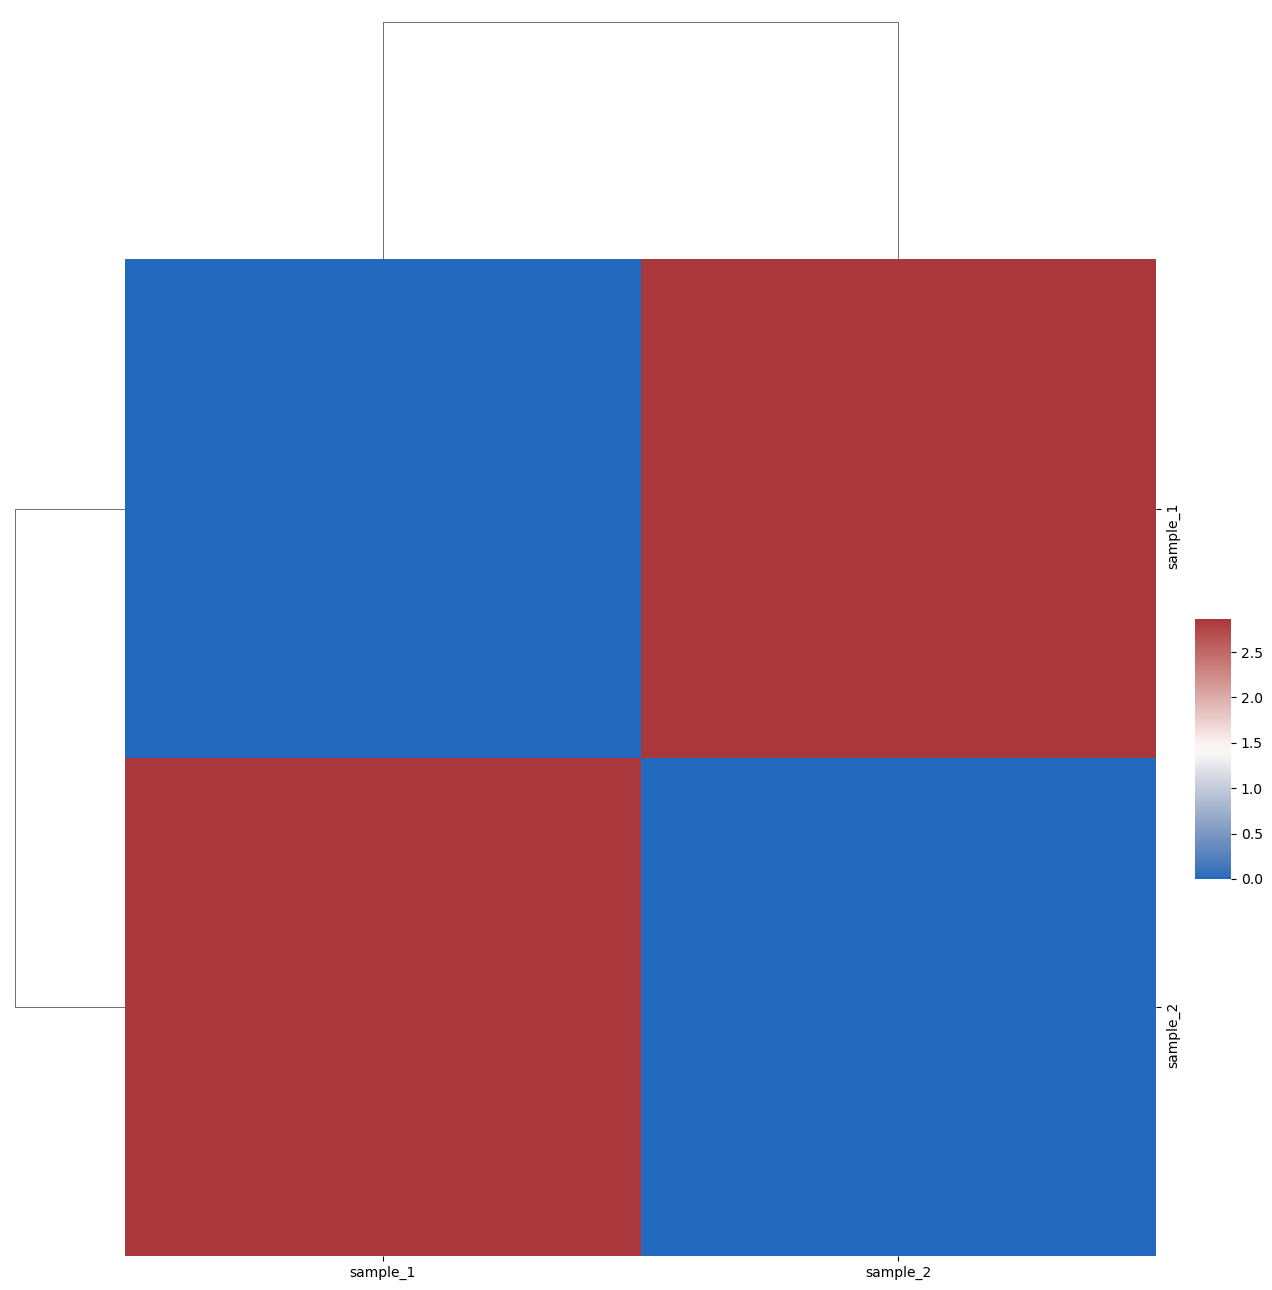

In [32]:
plot_distance.run()

### Possible implementation of the heatmap

In [57]:
import numpy as np

# Example probability distribution with a zero
distribution = np.array([0.2, 0.5, 0.3, 0.0])

# Smoothing parameter
epsilon = 1e-6

# Apply smoothing
smoothed_distribution = distribution + epsilon

# Normalize to ensure it sums to 1
smoothed_distribution /= smoothed_distribution.sum()

print("Original Distribution:", distribution)
print("Smoothed Distribution:", smoothed_distribution)


Original Distribution: [0.2 0.5 0.3 0. ]
Smoothed Distribution: [2.000002e-01 4.999990e-01 2.999998e-01 9.999960e-07]


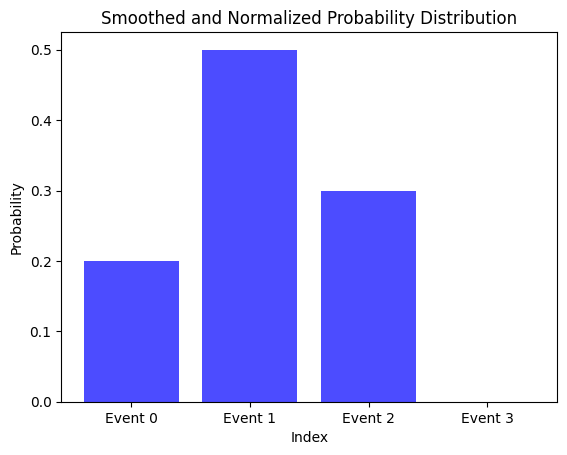

In [64]:
# Create a bar plot
plt.bar(range(len(smoothed_distribution)), smoothed_distribution, color='blue', alpha=0.7)
plt.title('Smoothed and Normalized Probability Distribution')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.xticks(range(len(smoothed_distribution)), labels=[f'Event {i}' for i in range(len(smoothed_distribution))])
plt.show()

In [69]:
import numpy as np

# Parameters for the normal distribution
mean = 0  # mean
std_dev = 1  # standard deviation
num_points = 1000  # number of data points

# Generate normally distributed data
data = np.random.normal(mean, std_dev, num_points)


In [67]:
data = distribution_one

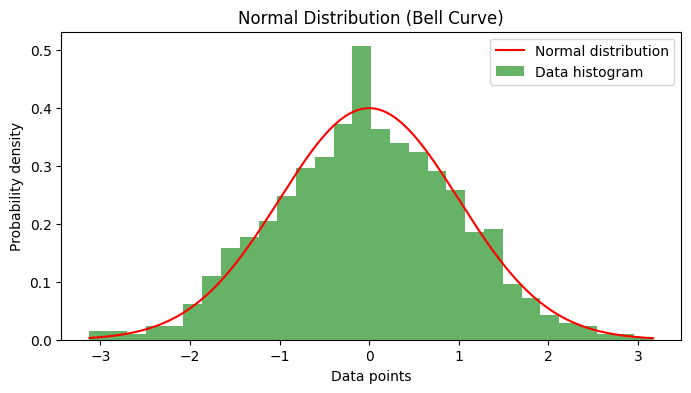

In [70]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Calculate the normal distribution's PDF (Probability Density Function)
x = np.linspace(min(data), max(data), num_points)
y = norm.pdf(x, mean, std_dev)

# Plotting the bell curve
plt.figure(figsize=(8, 4))
plt.plot(x, y, 'r-', label='Normal distribution')
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data histogram')
plt.title('Normal Distribution (Bell Curve)')
plt.xlabel('Data points')
plt.ylabel('Probability density')
plt.legend()
plt.show()


In [71]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# Define the distributions
dist1 = np.array([0.1, 0.2, 0.3, 0.1, 0.3])  # Longer distribution
dist2 = np.array([0.1, 0.2, 0.4])            # Shorter distribution

# Case 1: Without Padding
# Truncate dist1 to the length of dist2 for a fair comparison
dist1_truncated = dist1[:len(dist2)]
jsd_without_padding = jensenshannon(dist1_truncated, dist2, base=2)

# Case 2: Padding with Zero
target_length = len(dist1)
dist2_padded_zero = np.pad(dist2, (0, target_length - len(dist2)), 'constant', constant_values=(0,))
jsd_zero_padded = jensenshannon(dist1, dist2_padded_zero, base=2)

# Case 3: Padding with Epsilon
epsilon = 1e-6
dist2_padded_epsilon = np.pad(dist2, (0, target_length - len(dist2)), 'constant', constant_values=(epsilon,))
dist1_normalized = dist1 + epsilon  # Adding epsilon to all elements of dist1 as well
dist2_normalized = dist2_padded_epsilon + epsilon

# Normalize distributions to ensure they sum to 1
dist1_normalized /= dist1_normalized.sum()
dist2_normalized /= dist2_normalized.sum()

jsd_epsilon_padded = jensenshannon(dist1_normalized, dist2_normalized, base=2)

print("Jensen-Shannon Divergence without padding:", jsd_without_padding)
print("Jensen-Shannon Divergence with zero padding:", jsd_zero_padded)
print("Jensen-Shannon Divergence with epsilon padding:", jsd_epsilon_padded)


Jensen-Shannon Divergence without padding: 0.0608477735158521
Jensen-Shannon Divergence with zero padding: 0.4891136545438643
Jensen-Shannon Divergence with epsilon padding: 0.48906499409822396


In [72]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# Define the distributions
dist1 = np.array([0.1, 0.2, 0.3, 0.1, 0.3])  # Longer distribution
dist2 = np.array([0.1, 0.2, 0.4])            # Shorter distribution

# Epsilon for padding
epsilon = 1e-6
target_length = len(dist1)

# Padding with Epsilon
dist2_padded_epsilon = np.pad(dist2, (0, target_length - len(dist2)), 'constant', constant_values=(epsilon,))

# Case 1: Epsilon Padding without Smoothing
dist1_with_epsilon = dist1 + epsilon
jsd_epsilon_padded_without_smoothing = jensenshannon(dist1_with_epsilon, dist2_padded_epsilon, base=2)

# Case 2: Epsilon Padding with Smoothing
# Adding epsilon to all elements and then normalizing
dist1_normalized = dist1 + epsilon
dist2_normalized = dist2_padded_epsilon + epsilon
dist1_normalized /= dist1_normalized.sum()
dist2_normalized /= dist2_normalized.sum()

jsd_epsilon_padded_with_smoothing = jensenshannon(dist1_normalized, dist2_normalized, base=2)

print("Jensen-Shannon Divergence with epsilon padding (without smoothing):", jsd_epsilon_padded_without_smoothing)
print("Jensen-Shannon Divergence with epsilon padding (with smoothing):", jsd_epsilon_padded_with_smoothing)


Jensen-Shannon Divergence with epsilon padding (without smoothing): 0.48908793822094176
Jensen-Shannon Divergence with epsilon padding (with smoothing): 0.48906499409822396


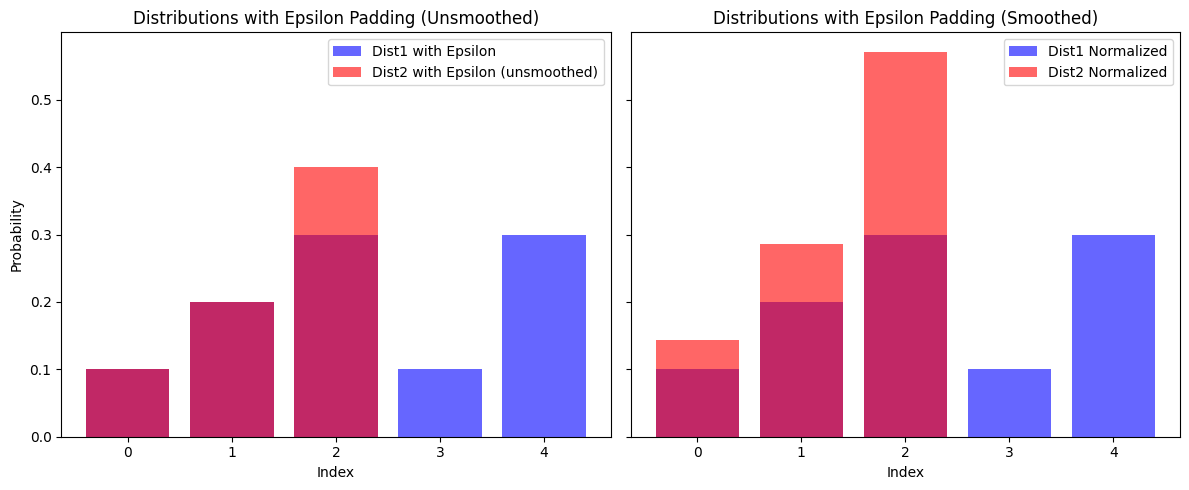

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Define the distributions
dist1 = np.array([0.1, 0.2, 0.3, 0.1, 0.3])  # Longer distribution
dist2 = np.array([0.1, 0.2, 0.4])            # Shorter distribution

# Epsilon for padding
epsilon = 1e-6
target_length = len(dist1)

# Padding with Epsilon
dist2_padded_epsilon = np.pad(dist2, (0, target_length - len(dist2)), 'constant', constant_values=(epsilon,))

# Distributions after padding with epsilon but without smoothing
dist1_with_epsilon = dist1 + epsilon
dist2_with_epsilon = dist2_padded_epsilon

# Normalizing the distributions
dist1_normalized = dist1_with_epsilon / dist1_with_epsilon.sum()
dist2_normalized = dist2_with_epsilon / dist2_with_epsilon.sum()

# Creating the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Without Smoothing
ax1.bar(range(len(dist1_with_epsilon)), dist1_with_epsilon, alpha=0.6, label='Dist1 with Epsilon', color='blue')
ax1.bar(range(len(dist2_with_epsilon)), dist2_with_epsilon, alpha=0.6, label='Dist2 with Epsilon (unsmoothed)', color='red')
ax1.set_title('Distributions with Epsilon Padding (Unsmoothed)')
ax1.set_xlabel('Index')
ax1.set_ylabel('Probability')
ax1.legend()

# With Smoothing
ax2.bar(range(len(dist1_normalized)), dist1_normalized, alpha=0.6, label='Dist1 Normalized', color='blue')
ax2.bar(range(len(dist2_normalized)), dist2_normalized, alpha=0.6, label='Dist2 Normalized', color='red')
ax2.set_title('Distributions with Epsilon Padding (Smoothed)')
ax2.set_xlabel('Index')
ax2.legend()

plt.tight_layout()
plt.show()


In [75]:
import numpy as np

def pad_and_normalize_distributions(distributions, epsilon=1e-6):
    # Determine the maximum length of any distribution in the list
    max_length = max(len(dist) for dist in distributions)

    # Pad all distributions to this maximum length with epsilon
    padded_distributions = [
        np.pad(dist, (0, max_length - len(dist)), 'constant', constant_values=(epsilon,))
        for dist in distributions
    ]

    # Normalize each distribution to ensure it sums to 1
    normalized_distributions = [
        dist / dist.sum() for dist in padded_distributions
    ]

    return normalized_distributions

# Example usage
distributions = [np.array([0.1, 0.2, 0.3]), np.array([0.1, 0.2]), np.array([0.3])]
normalized_distributions = pad_and_normalize_distributions(distributions)

# Now you can calculate the distance matrix using these normalized distributions


In [91]:
normalized_p_infer = pad_and_normalize_distributions(p_infer, epsilon=1e-20)

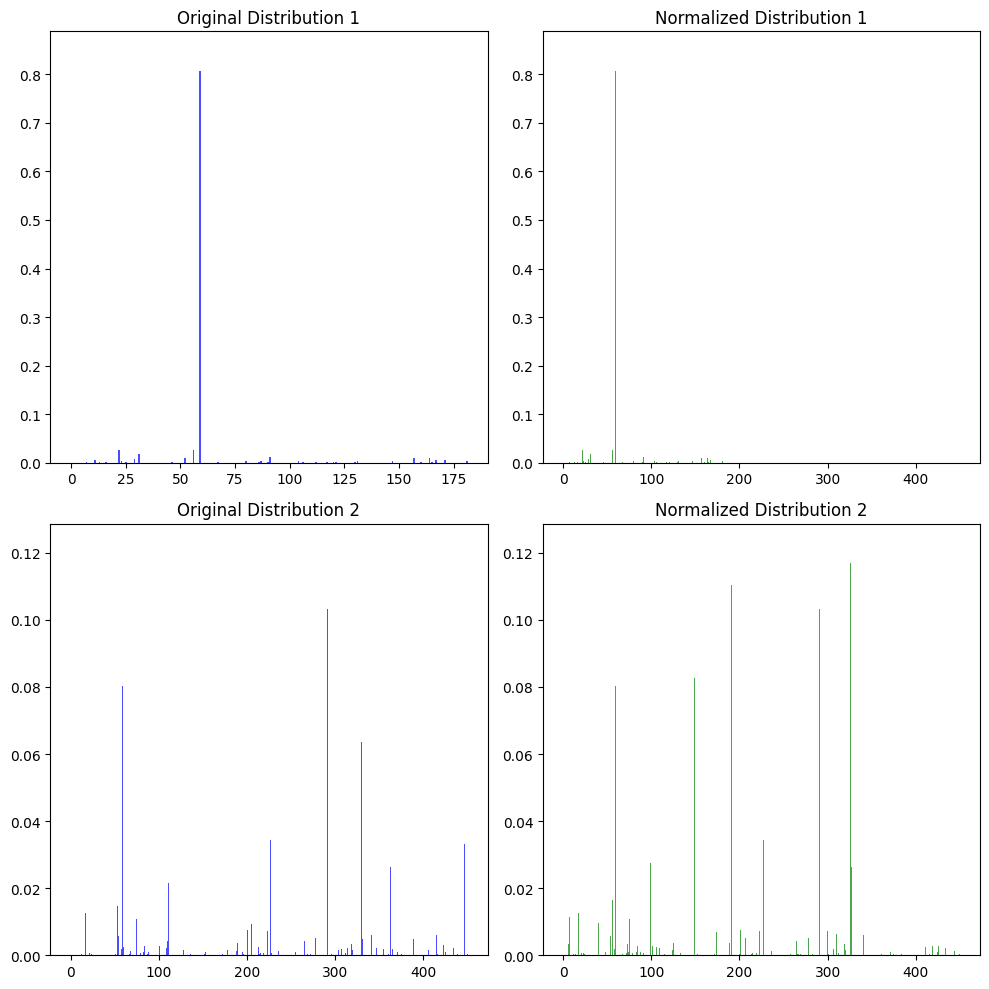

In [92]:
# Plotting
fig, axes = plt.subplots(nrows=len(p_infer), ncols=2, figsize=(10, 5 * len(p_infer)))

for i in range(len(p_infer)):
    # Original p_infer with padding visualized
    axes[i, 0].bar(range(len(p_infer[i])), p_infer[i], color='blue', alpha=0.7)
    axes[i, 0].set_title(f'Original Distribution {i+1}')
    axes[i, 0].set_ylim(0, 1.1 * max(p_infer[i]))
    
    # Normalized p_infer
    axes[i, 1].bar(range(len(normalized_p_infer[i])), normalized_p_infer[i], color='green', alpha=0.7)
    axes[i, 1].set_title(f'Normalized Distribution {i+1}')
    axes[i, 1].set_ylim(0, 1.1 * max(normalized_p_infer[i]))

# Add some spacing between plots
plt.tight_layout()
plt.show()